### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2025 Semester 2

## Assignment 1

**Student Name:**    `PLEASE ENTER YOUR NAME HERE`

**Student ID:**     `PLEASE ENTER YOUR ID HERE`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Draw wireframe cube from (x,y) points
def draw_cube(pts):

    # plot points
    plt.figure()
    plt.plot(pts[:, 0], pts[:, 1], 'k.')

    # define edges
    edges = np.array([
        [0, 1], [2, 3], [0, 2], [1, 3],
        [4, 5], [6, 7], [4, 6], [5, 7],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])

    # plot edges
    for edge in edges:
        plt.plot(pts[edge, 0], pts[edge, 1], 'k-')  # plot lines between connected edges

    # crop to sensor area (24 x 36 mm)
    plt.axis('equal')
    plt.xlim([-18, 18])
    plt.ylim([-12, 12])
    plt.show()

### 1. Mapping between world and image coordinates

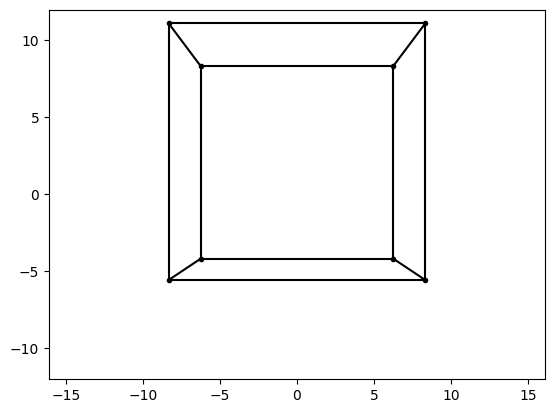

In [2]:
# corners of the cube in the image
xy_image = np.array([[-8.333333, -5.555556],
                     [8.333333, -5.555556],
                     [-8.333333, 11.11111],
                     [8.333333, 11.11111],
                     [-6.25, -4.166667],
                     [6.25, -4.166667],
                     [-6.25, 8.333333],
                     [6.25, 8.333333]])

# draw the cube
draw_cube(xy_image)

In [11]:

# Camera / scene parameters (mm)
f = 50.0
Z_front = 900.0
s = 300.0
Z_back = Z_front + s

# According to the setup, first 4 are the front face, last 4 are the back face
Z = np.array([Z_front]*4 + [Z_back]*4, dtype=float)

# Vectorised inverse projection: X = x*Z/f, Y = y*Z/f
X = xy_image[:, 0] * Z / f
Y = xy_image[:, 1] * Z / f

# Stack all individual coordinates back to 3D format
coords_world = np.column_stack([X, Y, Z])

# Labels matching the signs and your order:
corner_labels = [
    "F_BL", "F_BR", "F_TL", "F_TR",
    "B_BL", "B_BR", "B_TL", "B_TR"
]

# Print a neat table to display all 8 corners
print(f"{'Corner':<6} | {'X (mm)':>8} {'Y (mm)':>9} {'Z (mm)':>9}")
print("-"*40)
for lbl, (xw, yw, zw) in zip(corner_labels, coords_world):
    print(f"{lbl:<6} | {xw:8.0f} {yw:9.0f} {zw:9.0f}")


Corner |   X (mm)    Y (mm)    Z (mm)
----------------------------------------
F_BL   |     -150      -100       900
F_BR   |      150      -100       900
F_TL   |     -150       200       900
F_TR   |      150       200       900
B_BL   |     -150      -100      1200
B_BR   |      150      -100      1200
B_TL   |     -150       200      1200
B_TR   |      150       200      1200



=== Baseline (no translation) ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |  -150.0  -100.0   900.0  ->   -8.333  -5.556
F_BR  |   150.0  -100.0   900.0  ->    8.333  -5.556
F_TL  |  -150.0   100.0   900.0  ->   -8.333   5.556
F_TR  |   150.0   100.0   900.0  ->    8.333   5.556
B_BL  |  -150.0  -100.0  1200.0  ->   -6.250  -4.167
B_BR  |   150.0  -100.0  1200.0  ->    6.250  -4.167
B_TL  |  -150.0   100.0  1200.0  ->   -6.250   4.167
B_TR  |   150.0   100.0  1200.0  ->    6.250   4.167


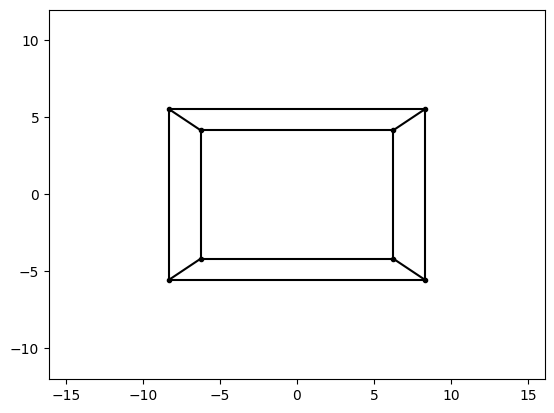


=== Translate +X (right) by 100 mm ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |   -50.0  -100.0   900.0  ->   -2.778  -5.556
F_BR  |   250.0  -100.0   900.0  ->   13.889  -5.556
F_TL  |   -50.0   100.0   900.0  ->   -2.778   5.556
F_TR  |   250.0   100.0   900.0  ->   13.889   5.556
B_BL  |   -50.0  -100.0  1200.0  ->   -2.083  -4.167
B_BR  |   250.0  -100.0  1200.0  ->   10.417  -4.167
B_TL  |   -50.0   100.0  1200.0  ->   -2.083   4.167
B_TR  |   250.0   100.0  1200.0  ->   10.417   4.167


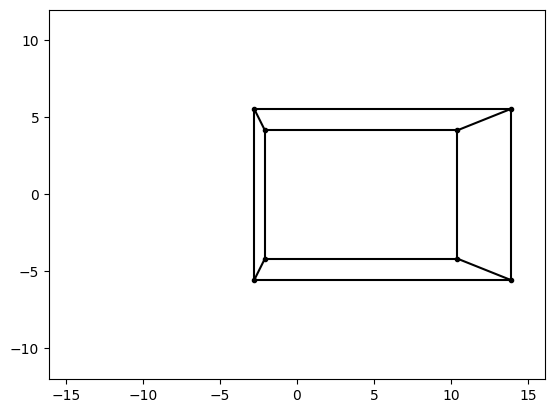


=== Translate +Y (up) by 100 mm ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |  -150.0     0.0   900.0  ->   -8.333   0.000
F_BR  |   150.0     0.0   900.0  ->    8.333   0.000
F_TL  |  -150.0   200.0   900.0  ->   -8.333  11.111
F_TR  |   150.0   200.0   900.0  ->    8.333  11.111
B_BL  |  -150.0     0.0  1200.0  ->   -6.250   0.000
B_BR  |   150.0     0.0  1200.0  ->    6.250   0.000
B_TL  |  -150.0   200.0  1200.0  ->   -6.250   8.333
B_TR  |   150.0   200.0  1200.0  ->    6.250   8.333


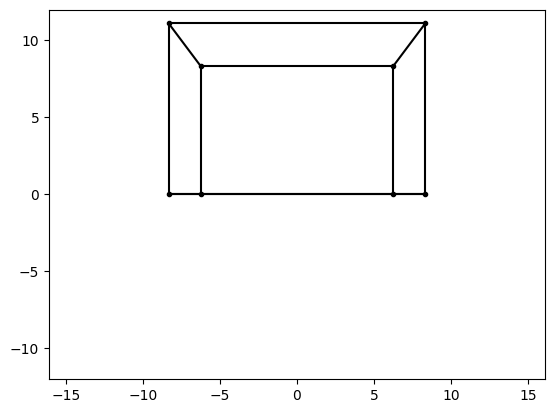


=== Translate -Z (closer) by 100 mm ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |  -150.0  -100.0   800.0  ->   -9.375  -6.250
F_BR  |   150.0  -100.0   800.0  ->    9.375  -6.250
F_TL  |  -150.0   100.0   800.0  ->   -9.375   6.250
F_TR  |   150.0   100.0   800.0  ->    9.375   6.250
B_BL  |  -150.0  -100.0  1100.0  ->   -6.818  -4.545
B_BR  |   150.0  -100.0  1100.0  ->    6.818  -4.545
B_TL  |  -150.0   100.0  1100.0  ->   -6.818   4.545
B_TR  |   150.0   100.0  1100.0  ->    6.818   4.545


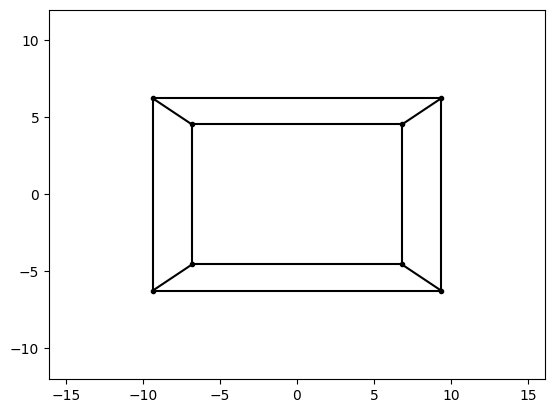


=== Translate +Z (farther) by 200 mm ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |  -150.0  -100.0  1100.0  ->   -6.818  -4.545
F_BR  |   150.0  -100.0  1100.0  ->    6.818  -4.545
F_TL  |  -150.0   100.0  1100.0  ->   -6.818   4.545
F_TR  |   150.0   100.0  1100.0  ->    6.818   4.545
B_BL  |  -150.0  -100.0  1400.0  ->   -5.357  -3.571
B_BR  |   150.0  -100.0  1400.0  ->    5.357  -3.571
B_TL  |  -150.0   100.0  1400.0  ->   -5.357   3.571
B_TR  |   150.0   100.0  1400.0  ->    5.357   3.571


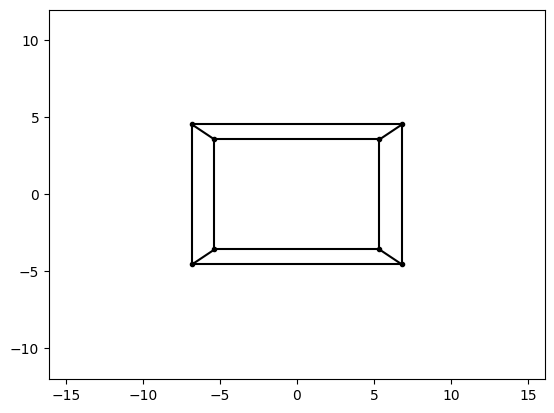


=== Translate +X,+Y,-Z (right/up/closer) ===
Corner |      Xw      Yw      Zw  ->        x       y  (mm)
--------------------------------------------------
F_BL  |   -70.0   -40.0   750.0  ->   -4.667  -2.667
F_BR  |   230.0   -40.0   750.0  ->   15.333  -2.667
F_TL  |   -70.0   160.0   750.0  ->   -4.667  10.667
F_TR  |   230.0   160.0   750.0  ->   15.333  10.667
B_BL  |   -70.0   -40.0  1050.0  ->   -3.333  -1.905
B_BR  |   230.0   -40.0  1050.0  ->   10.952  -1.905
B_TL  |   -70.0   160.0  1050.0  ->   -3.333   7.619
B_TR  |   230.0   160.0  1050.0  ->   10.952   7.619


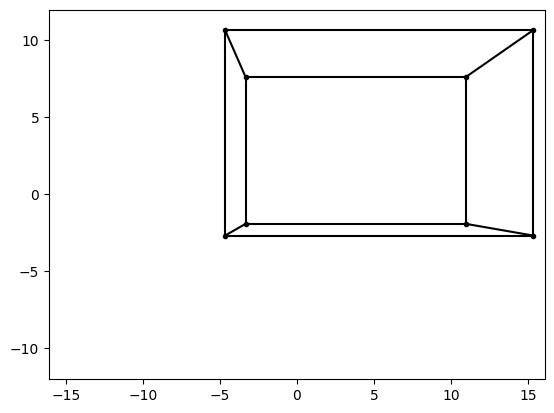

In [12]:
import numpy as np

# -------------------------------
# Camera / scene parameters (mm)
# -------------------------------
f = 50.0               # focal length (mm)
Z_front = 900.0        # Z of the front face (mm)
side = 300.0           # cube side length (mm)
Z_back  = Z_front + side

# ----------------------------------------------------
# 1) Define the cube in WORLD coordinates (baseline)
#    Layout matches your earlier convention:
#    Front face: Z=900, back face: Z=1200
#    X in [-150, +150], Y in [-100, +200] for your example
# ----------------------------------------------------
# Order: F_BL, F_BR, F_TL, F_TR, B_BL, B_BR, B_TL, B_TR (8x3)
cube_world = np.array([
    [-150.0, -100.0, Z_front],   # F_BL
    [ 150.0, -100.0, Z_front],   # F_BR
    [-150.0,  100.0, Z_front],   # F_TL
    [ 150.0,  100.0, Z_front],   # F_TR
    [-150.0, -100.0, Z_back ],   # B_BL
    [ 150.0, -100.0, Z_back ],   # B_BR
    [-150.0,  100.0, Z_back ],   # B_TL
    [ 150.0,  100.0, Z_back ],   # B_TR
], dtype=float)

# ----------------------------------------------------
# 2) World -> Image (pinhole)
#    Input: Pw (...,3) in mm, camera at origin, looking +Z
#    Output: pi (...,2) image coords (mm)
#    Formula: x = f * X/Z,  y = f * Y/Z
# ----------------------------------------------------
def world_to_image(Pw, f_mm):
    """
    Vectorised pinhole projection from world (mm) to image plane (mm).

    Parameters
    ----------
    Pw : ndarray (..., 3)
        World coordinates [X, Y, Z] in millimetres.
    f_mm : float
        Focal length in millimetres.

    Returns
    -------
    pi : ndarray (..., 2)
        Image coordinates [x, y] in millimetres.
    """
    X = Pw[..., 0]
    Y = Pw[..., 1]
    Z = Pw[..., 2]

    # Prevent division by zero / negative Z (behind camera)
    eps = 1e-9
    Z_safe = np.maximum(Z, eps)

    x = f_mm * X / Z_safe
    y = f_mm * Y / Z_safe
    return np.stack([x, y], axis=-1)

# ----------------------------------------------------
# 3) Translation in world
#    Simply add a translation vector t=[dX, dY, dZ] (mm)
# ----------------------------------------------------
def translate_world(Pw, t):
    """
    Translate world coordinates by a 3D vector t (mm).

    Parameters
    ----------
    Pw : ndarray (N, 3)
        World coordinates.
    t  : array-like (3,)
        Translation [dX, dY, dZ] in mm.

    Returns
    -------
    Pw_translated : ndarray (N, 3)
    """
    t = np.asarray(t, dtype=float).reshape(1, 3)
    return Pw + t

# ----------------------------------------------------
# 4) Helper to project a cube and draw it with your function
# ----------------------------------------------------
def project_and_draw_cube(Pw_cube, f_mm, title=None):
    """
    Projects a cube's 8 world corners to image coords and plots it.

    Assumes a provided function draw_cube(xy_image) that takes
    the 8x2 image points (in a consistent order) and renders a wireframe.

    Parameters
    ----------
    Pw_cube : ndarray (8, 3)
        World coordinates of the 8 cube corners.
    f_mm : float
        Focal length (mm).
    title : str or None
        Optional label for debugging/printing.
    """
    # Project world -> image
    xy = world_to_image(Pw_cube, f_mm)

    # Optional: print a compact table to verify numerically
    if title:
        print(f"\n=== {title} ===")
    print(f"{'Corner':<5} | {'Xw':>7} {'Yw':>7} {'Zw':>7}  ->  {'x':>7} {'y':>7}  (mm)")
    print("-"*50)
    labels = ["F_BL", "F_BR", "F_TL", "F_TR", "B_BL", "B_BR", "B_TL", "B_TR"]
    for lbl, (Pw, pi) in zip(labels, zip(Pw_cube, xy)):
        print(f"{lbl:<5} | {Pw[0]:7.1f} {Pw[1]:7.1f} {Pw[2]:7.1f}  ->  {pi[0]:7.3f} {pi[1]:7.3f}")

    # Draw using your existing plotting routine
    draw_cube(xy)

# ----------------------------------------------------
# 5) Verification examples
#    Try several translations to check left/right, up/down, near/far
# ----------------------------------------------------
# (a) No translation (baseline)
project_and_draw_cube(cube_world, f, title="Baseline (no translation)")

# (b) Move RIGHT by +100 mm in world (X direction) -> image x should shift right
Pw_right = translate_world(cube_world, t=[+100.0, 0.0, 0.0])
project_and_draw_cube(Pw_right, f, title="Translate +X (right) by 100 mm")

# (c) Move UP by +100 mm in world (Y direction) -> image y should shift up
Pw_up = translate_world(cube_world, t=[0.0, +100.0, 0.0])
project_and_draw_cube(Pw_up, f, title="Translate +Y (up) by 100 mm")

# (d) Move CLOSER by -100 mm in world (Z direction) -> image should get larger
Pw_closer = translate_world(cube_world, t=[0.0, 0.0, -100.0])
project_and_draw_cube(Pw_closer, f, title="Translate -Z (closer) by 100 mm")

# (e) Move FARTHER by +200 mm in world (Z direction) -> image should get smaller
Pw_farther = translate_world(cube_world, t=[0.0, 0.0, +200.0])
project_and_draw_cube(Pw_farther, f, title="Translate +Z (farther) by 200 mm")

# (f) A combined translation (right, up, closer)
Pw_combo = translate_world(cube_world, t=[+80.0, +60.0, -150.0])
project_and_draw_cube(Pw_combo, f, title="Translate +X,+Y,-Z (right/up/closer)")


### 2. Depth of field simulation

In [15]:
!unzip /content/COMP90086_asst1_2025_images.zip

Archive:  /content/COMP90086_asst1_2025_images.zip
  inflating: OldQuad.jpg             
  inflating: OldQuad-depth.png       
  inflating: OWeek.jpg               
  inflating: OWeek-depth.png         


In [16]:
# Example image
img = 'OWeek.jpg'
z_world = 'OWeek-depth.png' # Z_world in mm
f = 28 # focal length in mm

# Example image
img = 'OldQuad.jpg'
z_world = 'OldQuad-depth.png' # Z_world in mm
f = 24 # focal length in mm

# sensor width/height in mm
h_sensor = 24
w_sensor = 36

In [17]:
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage import gaussian_filter

# ------------------------------------------------------------
# Utility: load image and depth (Z_world) with proper dtypes
# ------------------------------------------------------------
def load_rgb_and_depth(img_path, depth_path):
    """
    Loads RGB image (H,W,3) and depth map (H,W) with Z in millimetres.
    Returns float32 arrays: I in [0,1], Z in mm.
    """
    I = imread(img_path).astype(np.float32)
    if I.max() > 1.0:
        I /= 255.0
    Z = imread(depth_path).astype(np.float32)
    # If depth is stored in 16-bit or scaled metres, you may need to rescale here.
    # This code assumes Z is already in millimetres per the assignment statement.
    return I, Z

# ------------------------------------------------------------
# Variant A: Hard focus band
# ------------------------------------------------------------
def dof_hard_band(I, Z, Zmin_mm, Zmax_mm, blur_sigma=3.0):
    """
    Keep [Zmin, Zmax] in focus; blur everything else with fixed sigma.
    I: (H,W,3) in [0,1]
    Z: (H,W) depth in mm
    """
    mask = (Z >= Zmin_mm) & (Z <= Zmax_mm)
    I_blur = gaussian_filter(I, sigma=(blur_sigma, blur_sigma, 0))
    out = np.where(mask[..., None], I, I_blur)
    return out, mask

# ------------------------------------------------------------
# Variant B: Soft, depth-aware blur via sigma binning
# ------------------------------------------------------------
def dof_soft_blur(I, Z, Zf_mm, k=2000.0, sigma_max=6.0, num_bins=7):
    """
    Depth-aware blur without per-pixel convolution:
    - sigma_raw = k * |1/Z - 1/Zf|
    - quantise sigma to discrete bins
    - precompute blurred images and blend per pixel

    Parameters
    ----------
    I : (H,W,3) float image in [0,1]
    Z : (H,W) depth in mm
    Zf_mm : focal depth (mm); pixels near Zf are sharp
    k : scale factor controlling blur growth (tune visually)
    sigma_max : clamp for blur
    num_bins : number of sigma levels

    Returns
    -------
    out : (H,W,3) simulated DoF image
    sigma_map : (H,W) per-pixel (quantised) sigma
    """
    eps = 1e-6
    invZ = 1.0 / np.maximum(Z, eps)
    invZf = 1.0 / max(Zf_mm, eps)

    sigma = k * np.abs(invZ - invZf)
    sigma = np.clip(sigma, 0.0, sigma_max)

    # Build bin edges and representatives
    bin_edges = np.linspace(0.0, sigma_max, num_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Assign each pixel to a bin (quantised sigma index)
    # np.digitize returns 1..num_bins; subtract 1 -> 0..num_bins-1
    idx = np.digitize(sigma, bin_edges[1:-1], right=False)

    # Precompute blurred versions for each bin center
    blurred_stack = []
    for s in bin_centers:
        if s <= 1e-6:
            blurred_stack.append(I)  # no blur needed
        else:
            blurred_stack.append(gaussian_filter(I, sigma=(float(s), float(s), 0)))
    blurred_stack = np.stack(blurred_stack, axis=0)  # (B,H,W,3)

    # Gather per-pixel from the stack using the bin index
    # We’ll do it channel-wise to avoid large temporary copies
    H, W, C = I.shape
    out = np.empty_like(I)
    for c in range(C):
        out[..., c] = blurred_stack[idx, np.arange(H)[:, None], np.arange(W)[None, :], c]

    return out, sigma

# ------------------------------------------------------------
# Helper: choose focus parameters from depth stats
# ------------------------------------------------------------
def choose_focus_from_percentile(Z, focus_percentile=40, band_mm=300):
    """
    Pick a focal depth at a depth percentile, and a +/- band around it for hard focus.
    Returns Zf (mm), Zmin (mm), Zmax (mm)
    """
    z_valid = Z[np.isfinite(Z) & (Z > 0)]
    if z_valid.size == 0:
        raise ValueError("Depth map seems invalid.")
    Zf = float(np.percentile(z_valid, focus_percentile))
    Zmin = max(1.0, Zf - band_mm)
    Zmax = Zf + band_mm
    return Zf, Zmin, Zmax

# ------------------------------------------------------------
# End-to-end examples for your two images
# ------------------------------------------------------------
# Example 1: OWeek
I_ow, Z_ow = load_rgb_and_depth('OWeek.jpg', 'OWeek-depth.png')
f_ow = 28.0  # mm (given)

# Choose focus parameters
Zf_ow, Zmin_ow, Zmax_ow = choose_focus_from_percentile(Z_ow, focus_percentile=40, band_mm=300)

# (A) Hard band
ow_hard, ow_mask = dof_hard_band(I_ow, Z_ow, Zmin_ow, Zmax_ow, blur_sigma=3.0)
imwrite('OWeek-DoF-hard.png', np.clip(ow_hard*255, 0, 255).astype(np.uint8))
imwrite('OWeek-mask.png', (ow_mask.astype(np.uint8)*255))

# (B) Soft DoF
ow_soft, ow_sigma = dof_soft_blur(I_ow, Z_ow, Zf_ow, k=2000.0, sigma_max=6.0, num_bins=7)
imwrite('OWeek-DoF-soft.png', np.clip(ow_soft*255, 0, 255).astype(np.uint8))

# Example 2: OldQuad
I_oq, Z_oq = load_rgb_and_depth('OldQuad.jpg', 'OldQuad-depth.png')
f_oq = 24.0  # mm (given)

Zf_oq, Zmin_oq, Zmax_oq = choose_focus_from_percentile(Z_oq, focus_percentile=50, band_mm=300)

oq_hard, oq_mask = dof_hard_band(I_oq, Z_oq, Zmin_oq, Zmax_oq, blur_sigma=3.0)
imwrite('OldQuad-DoF-hard.png', np.clip(oq_hard*255, 0, 255).astype(np.uint8))
imwrite('OldQuad-mask.png', (oq_mask.astype(np.uint8)*255))

oq_soft, oq_sigma = dof_soft_blur(I_oq, Z_oq, Zf_oq, k=2000.0, sigma_max=6.0, num_bins=7)
imwrite('OldQuad-DoF-soft.png', np.clip(oq_soft*255, 0, 255).astype(np.uint8))

print("Saved: OWeek-DoF-hard.png, OWeek-DoF-soft.png, OldQuad-DoF-hard.png, OldQuad-DoF-soft.png")


/tmp/ipython-input-1428694582.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imread(img_path).astype(np.float32)
/tmp/ipython-input-1428694582.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Z = imread(depth_path).astype(np.float32)


Saved: OWeek-DoF-hard.png, OWeek-DoF-soft.png, OldQuad-DoF-hard.png, OldQuad-DoF-soft.png


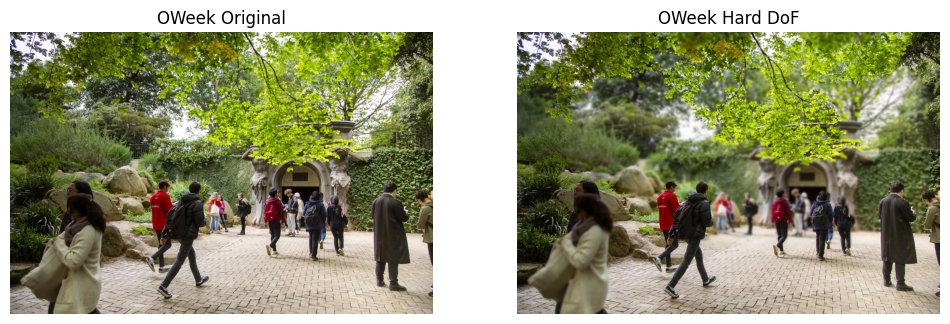

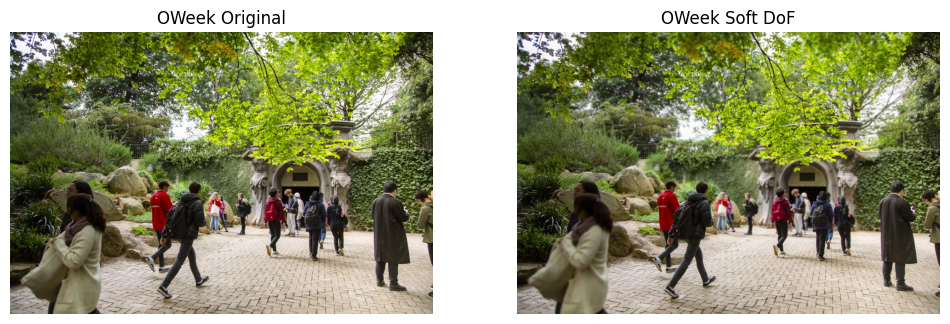

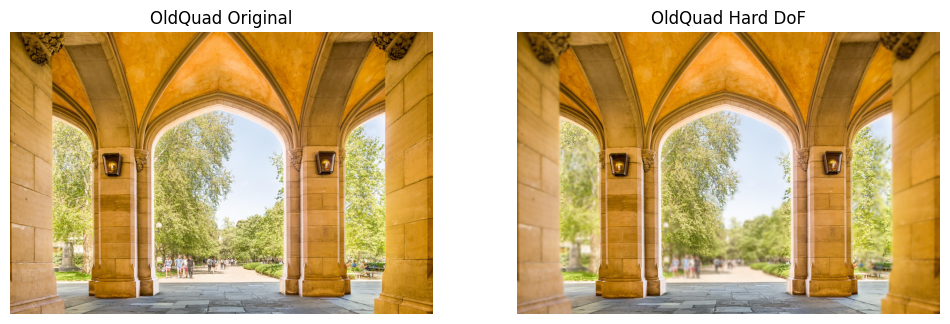

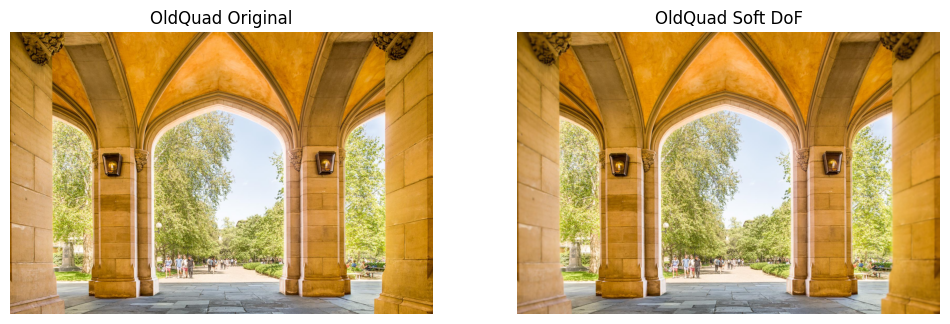

In [18]:
import matplotlib.pyplot as plt

def show_comparison(original, processed, title1="Original", title2="Processed"):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(np.clip(original,0,1))
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(np.clip(processed,0,1))
    plt.title(title2)
    plt.axis('off')
    plt.show()

# Example usage with OWeek
show_comparison(I_ow, ow_hard, "OWeek Original", "OWeek Hard DoF")
show_comparison(I_ow, ow_soft, "OWeek Original", "OWeek Soft DoF")

# Example usage with OldQuad
show_comparison(I_oq, oq_hard, "OldQuad Original", "OldQuad Hard DoF")
show_comparison(I_oq, oq_soft, "OldQuad Original", "OldQuad Soft DoF")
